<a href="https://colab.research.google.com/github/tudor108/human-emotion-detection/blob/main/54%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fer2013.zip
replace fer2013/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.2388 - loss: 1.8398 - val_accuracy: 0.2499 - val_loss: 1.7841 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.2449 - loss: 1.7972 - val_accuracy: 0.2882 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.2727 - loss: 1.7678 - val_accuracy: 0.3009 - val_loss: 1.6983 - learning_rate: 0.0010
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.2801 - loss: 1.7459 - val_accuracy: 0.3309 - val_loss: 1.6541 - learning_rate: 0.0010
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3005 - loss: 1.7099 - val_accuracy: 0.3309 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3131 - loss: 1.6869 - val_accuracy: 0.4145 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.3396 - loss: 1.6400

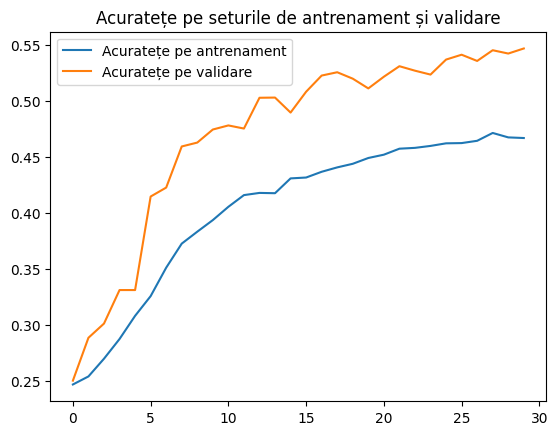

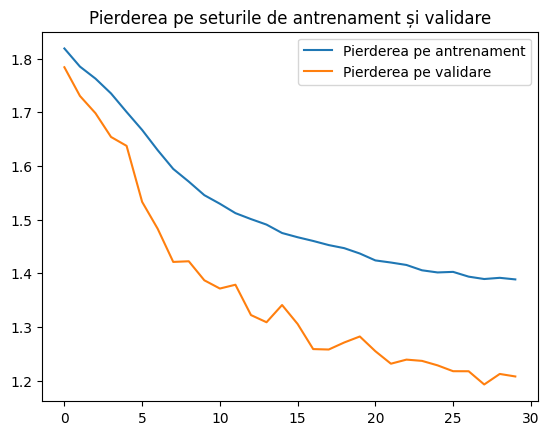

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5501 - loss: 1.1914
Accuracy pe setul de test: 0.5468477606773376


In [2]:
!pip install kaggle numpy pandas matplotlib seaborn tensorflow keras opencv-python scikit-learn

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Setează calea pentru fișierul Kaggle API Key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descarcă dataset-ul FER-2013
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d fer2013

IMG_SIZE = 48
emotions = os.listdir('fer2013/train')

X = []
y = []

for emotion in emotions:
    emotion_path = os.path.join('fer2013/train', emotion)
    for img_name in os.listdir(emotion_path):
        img = cv2.imread(os.path.join(emotion_path, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        y.append(emotion)

X = np.array(X)
y = np.array(y)

# Normalizarea imaginilor
X = X / 255.0

# Encodează etichetele
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = np.array([np.eye(len(emotions))[i] for i in y])

# Împarte setul de date în antrenament și test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adăugarea dimensiunii suplimentare pentru canale (1 canal pentru imagini în tonuri de gri)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Augmentarea datelor
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Crearea modelului CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(emotions), activation='softmax'))

# Compilarea modelului
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reducerea ratei de învățare la plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Antrenamentul modelului
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

# Grafic pentru acuratețea pe setul de antrenament și validare
plt.plot(history.history['accuracy'], label='Acuratețe pe antrenament')
plt.plot(history.history['val_accuracy'], label='Acuratețe pe validare')
plt.legend()
plt.title('Acuratețe pe seturile de antrenament și validare')
plt.show()

# Grafic pentru pierdere pe setul de antrenament și validare
plt.plot(history.history['loss'], label='Pierderea pe antrenament')
plt.plot(history.history['val_loss'], label='Pierderea pe validare')
plt.legend()
plt.title('Pierderea pe seturile de antrenament și validare')
plt.show()

# Evaluarea pe setul de test
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy pe setul de test: {test_acc}")

# Salvarea modelului
model.save('my_model.keras')
